# Transfer Learning and Custom Dataset

#### Contents
    1. Import Libraries
    2. Make a Custom Dataset using Google Image Crawler
    3. Import Pre-trained Model
    4. Train and Validation
    5. Test
    6. References

Nowadays, due to development of numerous powerful Convolutional Neural Network architectures and difficulty in collecting large set of data, people do not build and train an entire CNN from scratch. Instead, they import a pre-trained CNN model because it is proven that they perform better on similar tasks.

There are four types of transfer learning.
<img src = './images/TransferLearningTable.png'>

Note that when doing fine-tuning, layers in the front extracts general features thus layers in the back are fine-tuned and all the other layers are frozen (parameters are fixed and not changed). 

![TransferLearning](./Images/TransferLearning.png)

PyTorch provides pre-trained models via `torchvision.models`. Check the supported pre-trained models [here](https://pytorch.org/docs/stable/torchvision/models.html).

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import os
import copy
import time
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
print(device)

cpu


## 2. Make a Custom Dataset using Google Image Crawler
A custom dataset is made with assistance from [Google Images Download Documentation](https://google-images-download.readthedocs.io/en/latest/examples.html#). <br/>
<br> It is simple to use but the limitation of images per one download is 100 (Thus, it is recommended to augment dataset by putting different keywords). <br/>
<br> It crawles images from the google. Please note that, check the file format of downloaded files and if it is not jpeg or png, delete them for preventing future errors. 

In [4]:
!pip install google_images_download

In [5]:
# import the library

from google_images_download import google_images_download

In [6]:
def imageCrawler(keywords, directory):
    
    # class instantiation
    response = google_images_download.googleimagesdownload()
    
    # create the list of arguments
    arguments = {
        "keywords" : keywords, 
        "limit": 100, 
        "print_urls" : False, 
        "no_directory" : False, 
        "output_directory": directory
    }
    
    # pass the arguments to the file path
    path = response.download(arguments)

In [ ]:
imageCrawler('kakao friends ryan', 'Kakao')

In [ ]:
imageCrawler('kakao friends apeach', 'Kakao')

In [ ]:
imageCrawler('kakao friends muzi', 'Kakao')

Images that are not related to the `keywords` or may degrade the performance of the model should be deleted. Then, files should be re-allocated for processing, in the way of tree below.

<pre>/Kakao (main directory)
    /train (Purpose)
        /Apeach (Class 1)
        /Muzi (Class 2)
        /Ryan (Class 3)
    /Val (Purpose)
        /Apeach (Class 1)
        /Muzi (Class 2)
        /Ryan (Class 3)

In [7]:
transform = {
    'train' : transforms.Compose([transforms.RandomResizedCrop(256),
                                  transforms.RandomRotation(degrees = 15),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(), 
                                  transforms.Normalize(mean = (0.485, 0.456, 0.406), 
                                                       std = (0.299, 0.224, 0.225))
                                 ]),
    'val' : transforms.Compose([transforms.Resize(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean = (0.485, 0.456, 0.406), 
                                                     std = (0.299, 0.224, 0.225))
                               ])
}

In [8]:
dataset = {
    'train' : datasets.ImageFolder(root = './Kakao/Train', transform = transform['train']),
    'val' : datasets.ImageFolder(root = './Kakao/Val', transform = transform['val'])
}

In [9]:
dataloaders = {
    'train' : DataLoader(dataset['train'], batch_size = 4, shuffle = True),
    'val' : DataLoader(dataset['val'], batch_size = 4, shuffle = True)
}

In [10]:
dataset_sizes = {
    'train' : len(dataset['train']),
    'val' : len(dataset['val'])
}

In [11]:
dataset_sizes

{'train': 91, 'val': 27}

In [12]:
class_names = dataset['train'].classes

In [13]:
class_names, len(class_names)

(['Apeach', 'Muzi', 'Ryan'], 3)

shape has dimension of (batch_size, color_channels, height, width)

In [14]:
train_iter = iter(dataloaders['train'])
features, labels = next(train_iter)
features.shape, labels.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

Visualize train images to check if they are properly processed.

In [15]:
def imshow(image, title = None):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

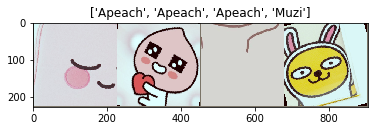

In [16]:
images, classes = next(iter(dataloaders['train']))
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

## 3. Import Pre-trained Model

As mentioned above, a model that is pre-trained on a large dataset will be used. As size of dataset is quite small and similarity of dataset is high, only last fully connected layer will be trained and other layers will not be trained (frozen). 

In [17]:
resnet = models.resnet18(pretrained = True)

In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Parameters are to be frozen and additional fully connected layers are attached to the top of the resnet18. 

In [19]:
for param in resnet.parameters():
    param.requires_grad = False

In [20]:
resnet.fc = nn.Sequential(nn.Linear(resnet.fc.in_features, 256), 
                   nn.ReLU(), 
                   nn.Dropout(0.5),
                   nn.Linear(256, len(class_names))
                  )

In [21]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Training and Validation

To classify 3 classes, `nn.CrossEntropyLoss()` is used. Optimization function is `Adam` with learning rate of 0.005. Entire training process is the same as classifying `CIFAR10` and `MNIST` dataset.

In [22]:
def train(model):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.005)
    
    # train mode
    model.train()
    
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # initialize optimizer
        optimizer.zero_grad()

        # forawrd pass
        pred = model(images)

        # calculate the loss
        loss = criterion(pred, labels)

        # back propagation and optimization
        loss.backward(retain_graph = True)
        optimizer.step()
        
        
    print("Epoch: %d/%d, Loss: %.4f"%(epoch+1, num_epochs, loss.item()))

In [23]:
def validation(model):
    
    # validation mode
    model.eval()
    
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(dataloaders['val']):
        images, labels = images.to(device), labels.to(device)
        
        # feed forward
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)[1]
        
        # add one to total and correct
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    print("Accuracy: %.4f"%(100 * float(correct)/total))

In [24]:
num_epochs = 20

for epoch in range(num_epochs):
    train(resnet)
    validation(resnet)

Epoch: 1/20, Loss: 0.5301
Accuracy: 48.1481
Epoch: 2/20, Loss: 0.9264
Accuracy: 37.0370
Epoch: 3/20, Loss: 0.2692
Accuracy: 70.3704
Epoch: 4/20, Loss: 0.8058
Accuracy: 81.4815
Epoch: 5/20, Loss: 1.2999
Accuracy: 74.0741
Epoch: 6/20, Loss: 1.6437
Accuracy: 66.6667
Epoch: 7/20, Loss: 1.0959
Accuracy: 70.3704
Epoch: 8/20, Loss: 2.6059
Accuracy: 62.9630
Epoch: 9/20, Loss: 1.1389
Accuracy: 74.0741
Epoch: 10/20, Loss: 1.7447
Accuracy: 62.9630
Epoch: 11/20, Loss: 0.8855
Accuracy: 70.3704
Epoch: 12/20, Loss: 1.2539
Accuracy: 77.7778
Epoch: 13/20, Loss: 0.3826
Accuracy: 85.1852
Epoch: 14/20, Loss: 1.1342
Accuracy: 85.1852
Epoch: 15/20, Loss: 1.0240
Accuracy: 74.0741
Epoch: 16/20, Loss: 0.8144
Accuracy: 66.6667
Epoch: 17/20, Loss: 1.1514
Accuracy: 70.3704
Epoch: 18/20, Loss: 1.0232
Accuracy: 66.6667
Epoch: 19/20, Loss: 0.8242
Accuracy: 74.0741
Epoch: 20/20, Loss: 1.0987
Accuracy: 77.7778


## 5. Test
Let's see how well the transfer learning is done with custom dataset. As the data size is quite small and despite data being augmented, we should not expect that much. 

In [25]:
def visualize_model(model, num_images = 2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloaders['val']):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predicted[j]]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

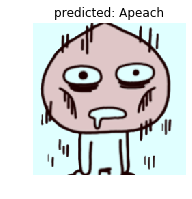

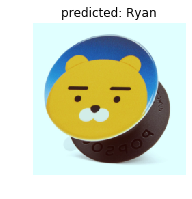

In [26]:
# be aware that num_images should be between 1 and 2.
visualize_model(resnet, 2)

## 6. References
- [PyTorch Official - Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)